In [5]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [6]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.51MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.26MB/s]


In [7]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
train_data.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [11]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [12]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [13]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    'test' : DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)
}

In [14]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x792e54d91f10>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x792e4c422f10>}

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):

  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)

    return F.softmax(x)

In [20]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(loaders['train']):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 20 == 0:
      print(f"Epoch {epoch} [{batch_idx * len(data)}/{len(loaders['train'].dataset)} ({100. * batch_idx / len(loaders['train']):.0f}%)]\t{loss.item():.6f}")
def test():
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in loaders['test']:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += loss_fn(output, target).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss / len(loaders['test'].dataset)
  print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.0f}%)")

In [21]:
for epoch in range(1, 11):
  train(epoch)
  test()

/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 1 [0/60000 (0%)]	2.300829
Epoch 1 [2000/60000 (3%)]	2.288104


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 1 [4000/60000 (7%)]	2.149008
Epoch 1 [6000/60000 (10%)]	1.968543
Epoch 1 [8000/60000 (13%)]	1.887668
Epoch 1 [10000/60000 (17%)]	1.853223
Epoch 1 [12000/60000 (20%)]	1.802384
Epoch 1 [14000/60000 (23%)]	1.744843
Epoch 1 [16000/60000 (27%)]	1.677442
Epoch 1 [18000/60000 (30%)]	1.723718
Epoch 1 [20000/60000 (33%)]	1.749873


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 1 [22000/60000 (37%)]	1.685909
Epoch 1 [24000/60000 (40%)]	1.713167
Epoch 1 [26000/60000 (43%)]	1.646426


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 1 [28000/60000 (47%)]	1.636515


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 1 [30000/60000 (50%)]	1.642119
Epoch 1 [32000/60000 (53%)]	1.629583
Epoch 1 [34000/60000 (57%)]	1.632972


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 1 [36000/60000 (60%)]	1.627285
Epoch 1 [38000/60000 (63%)]	1.581049


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 1 [40000/60000 (67%)]	1.695677
Epoch 1 [42000/60000 (70%)]	1.624607
Epoch 1 [44000/60000 (73%)]	1.611806
Epoch 1 [46000/60000 (77%)]	1.637011


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 1 [48000/60000 (80%)]	1.592929


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 1 [50000/60000 (83%)]	1.613562
Epoch 1 [52000/60000 (87%)]	1.664884
Epoch 1 [54000/60000 (90%)]	1.666826
Epoch 1 [56000/60000 (93%)]	1.636073


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 1 [58000/60000 (97%)]	1.605287


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)



Test set: Average loss: 153.7584, Accuracy: 9263/10000 (93%)


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 2 [0/60000 (0%)]	1.612164
Epoch 2 [2000/60000 (3%)]	1.696147
Epoch 2 [4000/60000 (7%)]	1.603070


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 2 [6000/60000 (10%)]	1.690502
Epoch 2 [8000/60000 (13%)]	1.582765


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 2 [10000/60000 (17%)]	1.574742
Epoch 2 [12000/60000 (20%)]	1.634117
Epoch 2 [14000/60000 (23%)]	1.651314


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 2 [16000/60000 (27%)]	1.555985
Epoch 2 [18000/60000 (30%)]	1.663395
Epoch 2 [20000/60000 (33%)]	1.631027
Epoch 2 [22000/60000 (37%)]	1.542722


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 2 [24000/60000 (40%)]	1.599059
Epoch 2 [26000/60000 (43%)]	1.551475
Epoch 2 [28000/60000 (47%)]	1.554765


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 2 [30000/60000 (50%)]	1.656716
Epoch 2 [32000/60000 (53%)]	1.566784
Epoch 2 [34000/60000 (57%)]	1.580567


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 2 [36000/60000 (60%)]	1.585684
Epoch 2 [38000/60000 (63%)]	1.594750
Epoch 2 [40000/60000 (67%)]	1.604316


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 2 [42000/60000 (70%)]	1.620751
Epoch 2 [44000/60000 (73%)]	1.565634


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 2 [46000/60000 (77%)]	1.546053
Epoch 2 [48000/60000 (80%)]	1.554736


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 2 [50000/60000 (83%)]	1.565440
Epoch 2 [52000/60000 (87%)]	1.537572
Epoch 2 [54000/60000 (90%)]	1.540896


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 2 [56000/60000 (93%)]	1.546153
Epoch 2 [58000/60000 (97%)]	1.543057


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)



Test set: Average loss: 151.3315, Accuracy: 9494/10000 (95%)


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 3 [0/60000 (0%)]	1.634587
Epoch 3 [2000/60000 (3%)]	1.612264
Epoch 3 [4000/60000 (7%)]	1.591953


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 3 [6000/60000 (10%)]	1.557459
Epoch 3 [8000/60000 (13%)]	1.560148
Epoch 3 [10000/60000 (17%)]	1.590169


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 3 [12000/60000 (20%)]	1.569914
Epoch 3 [14000/60000 (23%)]	1.563830
Epoch 3 [16000/60000 (27%)]	1.569336
Epoch 3 [18000/60000 (30%)]	1.584500
Epoch 3 [20000/60000 (33%)]	1.564452


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 3 [22000/60000 (37%)]	1.572236
Epoch 3 [24000/60000 (40%)]	1.574026


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 3 [26000/60000 (43%)]	1.615321
Epoch 3 [28000/60000 (47%)]	1.566565
Epoch 3 [30000/60000 (50%)]	1.539651
Epoch 3 [32000/60000 (53%)]	1.614130
Epoch 3 [34000/60000 (57%)]	1.578535
Epoch 3 [36000/60000 (60%)]	1.611212


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 3 [38000/60000 (63%)]	1.550105


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 3 [40000/60000 (67%)]	1.574923
Epoch 3 [42000/60000 (70%)]	1.531669
Epoch 3 [44000/60000 (73%)]	1.549984


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 3 [46000/60000 (77%)]	1.541417
Epoch 3 [48000/60000 (80%)]	1.564507
Epoch 3 [50000/60000 (83%)]	1.557150
Epoch 3 [52000/60000 (87%)]	1.564942


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 3 [54000/60000 (90%)]	1.572824


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 3 [56000/60000 (93%)]	1.571309
Epoch 3 [58000/60000 (97%)]	1.563386


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)



Test set: Average loss: 150.5451, Accuracy: 9552/10000 (96%)
Epoch 4 [0/60000 (0%)]	1.516687


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 4 [2000/60000 (3%)]	1.553144


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 4 [4000/60000 (7%)]	1.524742
Epoch 4 [6000/60000 (10%)]	1.540785


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 4 [8000/60000 (13%)]	1.552411
Epoch 4 [10000/60000 (17%)]	1.569087
Epoch 4 [12000/60000 (20%)]	1.544878


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 4 [14000/60000 (23%)]	1.542533
Epoch 4 [16000/60000 (27%)]	1.577497
Epoch 4 [18000/60000 (30%)]	1.526128
Epoch 4 [20000/60000 (33%)]	1.561860


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 4 [22000/60000 (37%)]	1.558368
Epoch 4 [24000/60000 (40%)]	1.557068
Epoch 4 [26000/60000 (43%)]	1.535087


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 4 [28000/60000 (47%)]	1.555042
Epoch 4 [30000/60000 (50%)]	1.555542
Epoch 4 [32000/60000 (53%)]	1.534397


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 4 [34000/60000 (57%)]	1.577760
Epoch 4 [36000/60000 (60%)]	1.556791
Epoch 4 [38000/60000 (63%)]	1.559626


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 4 [40000/60000 (67%)]	1.556432
Epoch 4 [42000/60000 (70%)]	1.546346
Epoch 4 [44000/60000 (73%)]	1.543023


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 4 [46000/60000 (77%)]	1.553904
Epoch 4 [48000/60000 (80%)]	1.556473
Epoch 4 [50000/60000 (83%)]	1.540858
Epoch 4 [52000/60000 (87%)]	1.565591


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 4 [54000/60000 (90%)]	1.537512
Epoch 4 [56000/60000 (93%)]	1.562083
Epoch 4 [58000/60000 (97%)]	1.546847


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)



Test set: Average loss: 149.7807, Accuracy: 9632/10000 (96%)


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 5 [0/60000 (0%)]	1.517964
Epoch 5 [2000/60000 (3%)]	1.553172
Epoch 5 [4000/60000 (7%)]	1.522710
Epoch 5 [6000/60000 (10%)]	1.522093
Epoch 5 [8000/60000 (13%)]	1.543671


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 5 [10000/60000 (17%)]	1.551613


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 5 [12000/60000 (20%)]	1.560617
Epoch 5 [14000/60000 (23%)]	1.591618
Epoch 5 [16000/60000 (27%)]	1.544046
Epoch 5 [18000/60000 (30%)]	1.549468


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 5 [20000/60000 (33%)]	1.569303
Epoch 5 [22000/60000 (37%)]	1.528356
Epoch 5 [24000/60000 (40%)]	1.545073
Epoch 5 [26000/60000 (43%)]	1.537800
Epoch 5 [28000/60000 (47%)]	1.524871


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 5 [30000/60000 (50%)]	1.585166


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 5 [32000/60000 (53%)]	1.534988
Epoch 5 [34000/60000 (57%)]	1.545490
Epoch 5 [36000/60000 (60%)]	1.530625


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 5 [38000/60000 (63%)]	1.545941
Epoch 5 [40000/60000 (67%)]	1.558370
Epoch 5 [42000/60000 (70%)]	1.570429
Epoch 5 [44000/60000 (73%)]	1.537841
Epoch 5 [46000/60000 (77%)]	1.573101
Epoch 5 [48000/60000 (80%)]	1.569925


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 5 [50000/60000 (83%)]	1.573161


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 5 [52000/60000 (87%)]	1.535477
Epoch 5 [54000/60000 (90%)]	1.521210
Epoch 5 [56000/60000 (93%)]	1.527942


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 5 [58000/60000 (97%)]	1.551895


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)



Test set: Average loss: 149.5933, Accuracy: 9657/10000 (97%)
Epoch 6 [0/60000 (0%)]	1.591911
Epoch 6 [2000/60000 (3%)]	1.520800
Epoch 6 [4000/60000 (7%)]	1.605262
Epoch 6 [6000/60000 (10%)]	1.597299


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 6 [8000/60000 (13%)]	1.503565


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 6 [10000/60000 (17%)]	1.544726
Epoch 6 [12000/60000 (20%)]	1.526511
Epoch 6 [14000/60000 (23%)]	1.541025


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 6 [16000/60000 (27%)]	1.551110
Epoch 6 [18000/60000 (30%)]	1.527831
Epoch 6 [20000/60000 (33%)]	1.528860
Epoch 6 [22000/60000 (37%)]	1.557230
Epoch 6 [24000/60000 (40%)]	1.552921


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 6 [26000/60000 (43%)]	1.567694
Epoch 6 [28000/60000 (47%)]	1.566224


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 6 [30000/60000 (50%)]	1.522712
Epoch 6 [32000/60000 (53%)]	1.484959
Epoch 6 [34000/60000 (57%)]	1.542983


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 6 [36000/60000 (60%)]	1.507452
Epoch 6 [38000/60000 (63%)]	1.567683
Epoch 6 [40000/60000 (67%)]	1.574041
Epoch 6 [42000/60000 (70%)]	1.561537


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 6 [44000/60000 (73%)]	1.534755
Epoch 6 [46000/60000 (77%)]	1.564155
Epoch 6 [48000/60000 (80%)]	1.568085


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 6 [50000/60000 (83%)]	1.543380
Epoch 6 [52000/60000 (87%)]	1.517030
Epoch 6 [54000/60000 (90%)]	1.563984
Epoch 6 [56000/60000 (93%)]	1.567176
Epoch 6 [58000/60000 (97%)]	1.561767


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)



Test set: Average loss: 149.2700, Accuracy: 9683/10000 (97%)
Epoch 7 [0/60000 (0%)]	1.532733
Epoch 7 [2000/60000 (3%)]	1.518804
Epoch 7 [4000/60000 (7%)]	1.543064


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 7 [6000/60000 (10%)]	1.562416


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 7 [8000/60000 (13%)]	1.506386
Epoch 7 [10000/60000 (17%)]	1.499341
Epoch 7 [12000/60000 (20%)]	1.564381


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 7 [14000/60000 (23%)]	1.544937
Epoch 7 [16000/60000 (27%)]	1.560213
Epoch 7 [18000/60000 (30%)]	1.560536
Epoch 7 [20000/60000 (33%)]	1.525558
Epoch 7 [22000/60000 (37%)]	1.581717
Epoch 7 [24000/60000 (40%)]	1.524598


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 7 [26000/60000 (43%)]	1.512035


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 7 [28000/60000 (47%)]	1.533031
Epoch 7 [30000/60000 (50%)]	1.539962
Epoch 7 [32000/60000 (53%)]	1.542221


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 7 [34000/60000 (57%)]	1.495464
Epoch 7 [36000/60000 (60%)]	1.539309
Epoch 7 [38000/60000 (63%)]	1.518269
Epoch 7 [40000/60000 (67%)]	1.495297
Epoch 7 [42000/60000 (70%)]	1.547056


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 7 [44000/60000 (73%)]	1.516445


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 7 [46000/60000 (77%)]	1.531466
Epoch 7 [48000/60000 (80%)]	1.559577
Epoch 7 [50000/60000 (83%)]	1.549221


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 7 [52000/60000 (87%)]	1.552982
Epoch 7 [54000/60000 (90%)]	1.524813
Epoch 7 [56000/60000 (93%)]	1.538143
Epoch 7 [58000/60000 (97%)]	1.551359


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)



Test set: Average loss: 149.0885, Accuracy: 9702/10000 (97%)


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 8 [0/60000 (0%)]	1.546830
Epoch 8 [2000/60000 (3%)]	1.555327
Epoch 8 [4000/60000 (7%)]	1.562447
Epoch 8 [6000/60000 (10%)]	1.511798


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 8 [8000/60000 (13%)]	1.512161


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 8 [10000/60000 (17%)]	1.552665
Epoch 8 [12000/60000 (20%)]	1.520268
Epoch 8 [14000/60000 (23%)]	1.520074


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 8 [16000/60000 (27%)]	1.559341
Epoch 8 [18000/60000 (30%)]	1.531937
Epoch 8 [20000/60000 (33%)]	1.544468


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 8 [22000/60000 (37%)]	1.519052
Epoch 8 [24000/60000 (40%)]	1.541769
Epoch 8 [26000/60000 (43%)]	1.505835


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 8 [28000/60000 (47%)]	1.528544
Epoch 8 [30000/60000 (50%)]	1.542066
Epoch 8 [32000/60000 (53%)]	1.511112


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 8 [34000/60000 (57%)]	1.504425
Epoch 8 [36000/60000 (60%)]	1.551342
Epoch 8 [38000/60000 (63%)]	1.571138
Epoch 8 [40000/60000 (67%)]	1.511371


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 8 [42000/60000 (70%)]	1.489985
Epoch 8 [44000/60000 (73%)]	1.517020


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 8 [46000/60000 (77%)]	1.525641
Epoch 8 [48000/60000 (80%)]	1.559009
Epoch 8 [50000/60000 (83%)]	1.545571


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 8 [52000/60000 (87%)]	1.557964
Epoch 8 [54000/60000 (90%)]	1.515934


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 8 [56000/60000 (93%)]	1.501274
Epoch 8 [58000/60000 (97%)]	1.500713


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)



Test set: Average loss: 148.9096, Accuracy: 9720/10000 (97%)
Epoch 9 [0/60000 (0%)]	1.514722


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 9 [2000/60000 (3%)]	1.512940
Epoch 9 [4000/60000 (7%)]	1.533541
Epoch 9 [6000/60000 (10%)]	1.514413
Epoch 9 [8000/60000 (13%)]	1.505641
Epoch 9 [10000/60000 (17%)]	1.489398


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 9 [12000/60000 (20%)]	1.498541


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 9 [14000/60000 (23%)]	1.528887
Epoch 9 [16000/60000 (27%)]	1.517263
Epoch 9 [18000/60000 (30%)]	1.564138


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 9 [20000/60000 (33%)]	1.481683
Epoch 9 [22000/60000 (37%)]	1.496711
Epoch 9 [24000/60000 (40%)]	1.555681


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 9 [26000/60000 (43%)]	1.539512
Epoch 9 [28000/60000 (47%)]	1.558312
Epoch 9 [30000/60000 (50%)]	1.543569


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 9 [32000/60000 (53%)]	1.520907
Epoch 9 [34000/60000 (57%)]	1.506636
Epoch 9 [36000/60000 (60%)]	1.550401


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 9 [38000/60000 (63%)]	1.545495
Epoch 9 [40000/60000 (67%)]	1.505390
Epoch 9 [42000/60000 (70%)]	1.517864


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 9 [44000/60000 (73%)]	1.551339
Epoch 9 [46000/60000 (77%)]	1.509629
Epoch 9 [48000/60000 (80%)]	1.541089
Epoch 9 [50000/60000 (83%)]	1.514088


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 9 [52000/60000 (87%)]	1.511563
Epoch 9 [54000/60000 (90%)]	1.534665
Epoch 9 [56000/60000 (93%)]	1.550707


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 9 [58000/60000 (97%)]	1.525000


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)



Test set: Average loss: 148.7125, Accuracy: 9740/10000 (97%)
Epoch 10 [0/60000 (0%)]	1.540387


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 10 [2000/60000 (3%)]	1.533977
Epoch 10 [4000/60000 (7%)]	1.519693
Epoch 10 [6000/60000 (10%)]	1.541768


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 10 [8000/60000 (13%)]	1.497756


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 10 [10000/60000 (17%)]	1.542399
Epoch 10 [12000/60000 (20%)]	1.509513
Epoch 10 [14000/60000 (23%)]	1.510051


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 10 [16000/60000 (27%)]	1.561133
Epoch 10 [18000/60000 (30%)]	1.587750
Epoch 10 [20000/60000 (33%)]	1.532501


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 10 [22000/60000 (37%)]	1.548452
Epoch 10 [24000/60000 (40%)]	1.526195
Epoch 10 [26000/60000 (43%)]	1.561160
Epoch 10 [28000/60000 (47%)]	1.509395


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 10 [30000/60000 (50%)]	1.545360
Epoch 10 [32000/60000 (53%)]	1.530064


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 10 [34000/60000 (57%)]	1.547422
Epoch 10 [36000/60000 (60%)]	1.516373
Epoch 10 [38000/60000 (63%)]	1.552477


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 10 [40000/60000 (67%)]	1.534677
Epoch 10 [42000/60000 (70%)]	1.489735
Epoch 10 [44000/60000 (73%)]	1.545992
Epoch 10 [46000/60000 (77%)]	1.525000
Epoch 10 [48000/60000 (80%)]	1.534875
Epoch 10 [50000/60000 (83%)]	1.541321


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 10 [52000/60000 (87%)]	1.534332


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 10 [54000/60000 (90%)]	1.507623
Epoch 10 [56000/60000 (93%)]	1.552933
Epoch 10 [58000/60000 (97%)]	1.560141


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)



Test set: Average loss: 148.5870, Accuracy: 9756/10000 (98%)


Prediction: 0


/tmp/ipython-input-15-3333616915.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


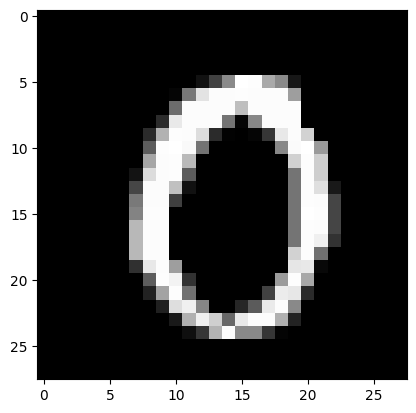

In [25]:
import matplotlib.pyplot as plt

model.eval()
data, target = test_data[13]
data = data.unsqueeze(0).to(device)
output = model(data)
prediction = output.argmax(dim=1, keepdim=True).item()
print(f'Prediction: {prediction}')
image = data.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(image, cmap='gray')
plt.show()